### Problem Statement

LTFS receives a lot of requests for its various finance offerings that include housing loan, two-wheeler loan, real estate financing and micro loans. The number of applications received is something that varies a lot with season. Going through these applications is a manual process and is tedious. Accurately forecasting the number of cases received can help with resource and manpower management resulting into quick response on applications and more efficient processing.

You have been appointed with the task of forecasting daily cases for next 3 months for 2 different business segments at the country level keeping in consideration the following major Indian festivals (inclusive but not exhaustive list): Diwali, Dussehra, Ganesh Chaturthi, Navratri, Holi etc. (You are free to use any publicly available open source external datasets). Some other examples could be:

Weather
Macroeconomic variables
 Note that the external dataset must belong to a reliable source.

![](http://)### Importing Packages & Data into dir

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
import re
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import monthrange

/kaggle/input/india-holiday-dataset/holiday data.csv
/kaggle/input/ltfs-2/test_1eLl9Yf.csv
/kaggle/input/ltfs-2/train_fwYjLYX.csv


*The codes in this kernal is not completely written by me, I have taken teh code samples from various resources from other kernals in kaggle & stackoverflow.*

##### Basic Setups

In [2]:
# # To increase the size of the cell
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))  # To change the cell size

**Us[](http://)er defined Functions******

In [3]:
#From fastai's module
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
        
def printColumnInfo(df):
    template="%-8s %-30s %s"
    print(template % ("Type", "Column Name", "Example Value"))
    print("-"*53)
    for c in df.columns:
        print(template % (df[c].dtype, c, df[c].iloc[1]) )
        
#To get over all idea about the columns in dataset like count of unique values, type, % of missing values

def describe_df(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=False)
    return stats_df


def plot_correlation_map(df):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )
    
    
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Importing dataset

In [4]:
#Importing train csv file
df_raw_train_path =  ('/kaggle/input/ltfs-2/train_fwYjLYX.csv') # Setting path for respective file
df_raw_train = pd.read_csv(df_raw_train_path) # importing train file
del df_raw_train_path # deleting the path variable


#Importing test csv file
df_raw_test_path =  ('/kaggle/input/ltfs-2/test_1eLl9Yf.csv') # Setting path for respective file
df_raw_test = pd.read_csv(df_raw_test_path) # importing test file
del df_raw_test_path # deleting the path variable

#Importing test csv file
df_raw_holiday_path =  ('/kaggle/input/india-holiday-dataset/holiday data.csv') # Setting path for respective file
df_raw_holiday = pd.read_csv(df_raw_holiday_path) # importing holiday file
del df_raw_holiday_path # deleting the path variable

In [5]:
#Creating Backups
df_raw_train_backup = df_raw_train.copy()
df_raw_test_backup = df_raw_test.copy()

##### Looking through the files

In [6]:
print('Training Data shape',df_raw_train.shape,'\n')
printColumnInfo(df_raw_train)
df_raw_train.head()

Training Data shape (80402, 6) 

Type     Column Name                    Example Value
-----------------------------------------------------
object   application_date               2017-04-03
int64    segment                        1
float64  branch_id                      1.0
object   state                          WEST BENGAL
object   zone                           EAST
float64  case_count                     5.0


,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4.0
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113.0
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76.0


In [7]:
print('Testing Data shape',df_raw_test.shape,'\n')
printColumnInfo(df_raw_test)
df_raw_test.head()

Testing Data shape (180, 3) 

Type     Column Name                    Example Value
-----------------------------------------------------
int64    id                             2
object   application_date               2019-07-07
int64    segment                        1


,id,application_date,segment
0,1,2019-07-06,1
1,2,2019-07-07,1
2,3,2019-07-08,1
3,4,2019-07-09,1
4,5,2019-07-10,1


In [8]:
print('Data available in training set',df_raw_train.application_date.min(), 'to ' ,df_raw_train.application_date.max())
print('Data available in testing set',df_raw_test.application_date.min(), 'to ' ,df_raw_test.application_date.max())

Data available in training set 2017-04-01 to  2019-07-23
Data available in testing set 2019-07-06 to  2019-10-24


**How many applciations we get?

In [9]:
train_dt_casecount = df_raw_train.groupby(['application_date','segment'])['case_count'].sum().reset_index()
%matplotlib inline
fig = go.Figure([go.Scatter(x=train_dt_casecount['application_date'], y=train_dt_casecount['case_count'])])
fig.show()

On a high level we can clearly see a trend between months

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_dt_casecount[train_dt_casecount.segment==1].application_date , y=train_dt_casecount[train_dt_casecount.segment==1].case_count, name="segment 1",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=train_dt_casecount[train_dt_casecount.segment==2].application_date , y=train_dt_casecount[train_dt_casecount.segment==2].case_count, name="segment 2",
                         line_color='dimgray'))

fig.update_layout(title_text='Time Series segmented by segment 1 & 2',
                  xaxis_rangeslider_visible=True)
fig.show()

We can see that segment 1 case count increase at regular interval of segment 2's dip

In [11]:
df_raw_train.application_date = pd.to_datetime(df_raw_train.application_date)
df_raw_test.application_date = pd.to_datetime(df_raw_test.application_date)

In [12]:
add_datepart(df_raw_train,'application_date', drop = False)
#add_datepart(df_raw_test,'application_date')

Does Day of the week has an impact?

In [13]:
ipo = df_raw_train.groupby(['application_Year', 'application_Month','application_Dayofweek','segment'])['case_count'].median().reset_index()

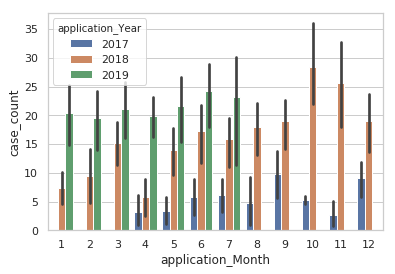

In [14]:
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
ax = sns.barplot(x="application_Month", y="case_count", hue="application_Year", data=ipo[ipo.segment == 1])
# 0-Monday ; 1- Tuesday ; 5- Saturday ; 6- Sunday

1. Does application_Week has an impact in counts?

In [15]:
ipo = df_raw_train.groupby(['application_Week','segment'])['case_count'].mean().reset_index()

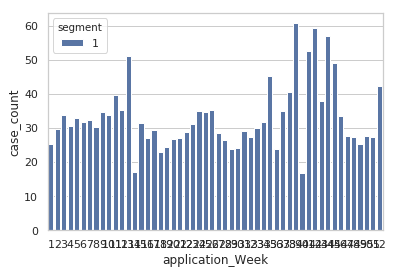

In [16]:
%matplotlib inline
ax = sns.barplot(x="application_Week", y="case_count", hue="segment", data=ipo[ipo.segment==1])

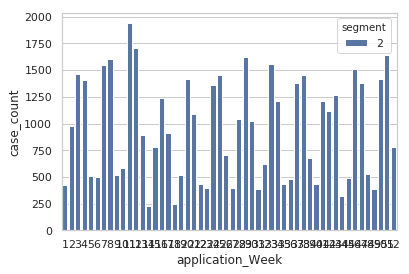

In [17]:
%matplotlib inline
ax = sns.barplot(x="application_Week", y="case_count", hue="segment", data=ipo[ipo.segment==2])

In [18]:
df_raw_train = df_raw_train_backup.copy()
df_raw_test = df_raw_test_backup.copy()
df_raw_train.application_date = pd.to_datetime(df_raw_train.application_date) 
df_raw_test.application_date = pd.to_datetime(df_raw_test.application_date) 

In [19]:
#Lets seperate the training data based on segment
df_raw_train_seg1 = df_raw_train[df_raw_train.segment == 1]
df_raw_train_seg2 = df_raw_train[df_raw_train.segment == 2]

In [20]:
# Lets see if we have any missing values
print(df_raw_train_seg1.isna().sum())
print(df_raw_train_seg2.isna().sum())

application_date    0
segment             0
branch_id           0
state               0
zone                0
case_count          0
dtype: int64
application_date        0
segment                 0
branch_id           13504
state                   0
zone                13504
case_count              0
dtype: int64


We have missing values in branch_id & in zone for segment 2 df alone, anyway for now since our testing data is at country level lets groupby using application date

In [21]:
df_raw_train_seg1 = df_raw_train_seg1.groupby('application_date')['case_count'].sum().reset_index()
df_raw_train_seg2 = df_raw_train_seg2.groupby('application_date')['case_count'].sum().reset_index()

In [22]:
df_raw_train_seg1.set_index('application_date', inplace=True)
df_raw_train_seg2.set_index('application_date', inplace=True)

In [23]:
print('Days in Segment 1',df_raw_train_seg1.index.max() - df_raw_train_seg1.index.min())
print('Unique Dates in Segment 1',df_raw_train_seg1.index.nunique())
print('Days in Segment 2',df_raw_train_seg2.index.max() - df_raw_train_seg2.index.min())
print('Unique Dates in Segment 2',df_raw_train_seg2.index.nunique())

Days in Segment 1 825 days 00:00:00
Unique Dates in Segment 1 806
Days in Segment 2 843 days 00:00:00
Unique Dates in Segment 2 844


We can see that we have missing dates, lets fill those first

###### Missing dates for each segment

In [24]:
#Missing dates in segment 1
pd.date_range(start = df_raw_train_seg1.index.min(), end = df_raw_train_seg1.index.max() ).difference(df_raw_train_seg1.index)

DatetimeIndex(['2017-04-02', '2017-04-06', '2017-04-08', '2017-04-09',
               '2017-04-10', '2017-04-11', '2017-05-06', '2017-07-03',
               '2017-07-04', '2017-07-08', '2017-07-09', '2017-08-02',
               '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-06',
               '2018-01-07', '2018-02-04', '2018-03-02', '2018-03-04'],
              dtype='datetime64[ns]', freq=None)

In [25]:
#Missing dates in segment 2
pd.date_range(start = df_raw_train_seg2.index.min(), end = df_raw_train_seg2.index.max() ).difference(df_raw_train_seg2.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

###### Insights :  
-  We have totally 5 columns in training (excluding the target column 'case_count') but only 2 columns in test (excluding the id column)
        - Missing columns in test are [branch_id, state, zone]
   This means we have to train the model at country level & not at branch_id level
- The training data for segment 1 is from 2017-04-01 to 2019-07-05,825 days, we have missing dates
- The training data for segment 2 is from 2017-04-01 to 2019-07-23,843 days

###### Lets include the missing dates for each sement

In [26]:
# resetting the index (application_date)
df_raw_train_seg1.reset_index(inplace=True)
df_raw_train_seg2.reset_index(inplace=True)

In [27]:
seg1_dates = pd.DataFrame(pd.date_range(start = df_raw_train_seg1.application_date.min(), end = df_raw_train_seg1.application_date.max() ))
seg1_dates.columns = ['application_date']

seg2_dates = pd.DataFrame(pd.date_range(start = df_raw_train_seg2.application_date.min(), end = df_raw_train_seg2.application_date.max() ))
seg2_dates.columns = ['application_date']

In [28]:
df_raw_train_seg1 = pd.merge(seg1_dates, df_raw_train_seg1,how = 'left', on ='application_date')
df_raw_train_seg2 = pd.merge(seg2_dates, df_raw_train_seg2,how = 'left', on ='application_date')

In [29]:
#Check if we have any more missing dates
df_raw_train_seg1.set_index('application_date', inplace=True)
df_raw_train_seg2.set_index('application_date', inplace=True)

print(pd.date_range(start = min(df_raw_train_seg1.index), end = max(df_raw_train_seg1.index) ).difference(df_raw_train_seg1.index))
print(pd.date_range(start = min(df_raw_train_seg2.index), end = max(df_raw_train_seg2.index) ).difference(df_raw_train_seg2.index))

DatetimeIndex([], dtype='datetime64[ns]', freq='D')
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [30]:
#Filling the missing values using linear method
df_raw_train_seg1['case_count'].interpolate(method='linear',inplace = True)

Now its time to make the validation set in accordance with the test set to make sure the model validation is done right before predicting the model on the original test set

###### How we can create the validation set?

In [31]:
df_raw_test_seg1 = df_raw_test[df_raw_test.segment == 1]
df_raw_test_seg2 = df_raw_test[df_raw_test.segment == 2]

In [32]:
print('Segment 1 train data from ', df_raw_train_seg1.index.min(),'to',df_raw_train_seg1.index.max())
print('Segment 1 test data from ', df_raw_test_seg1.application_date.min(),'to',df_raw_test_seg1.application_date.max())
print('Segment 1 test number of days', df_raw_test_seg1.application_date.min()-df_raw_test_seg1.application_date.max())

Segment 1 train data from  2017-04-01 00:00:00 to 2019-07-05 00:00:00
Segment 1 test data from  2019-07-06 00:00:00 to 2019-09-30 00:00:00
Segment 1 test number of days -86 days +00:00:00


 <font color='green'> For segment 1 we have data up to 5th of July and we need to predict for next 86 days </font>

In [33]:
print('Segment 2 train data from ', df_raw_train_seg2.index.min(),'to',df_raw_train_seg2.index.max())
print('Segment 2 test data from ', df_raw_test_seg2.application_date.min(),'to',df_raw_test_seg2.application_date.max())
print('Segment 2 test number of days', df_raw_test_seg2.application_date.min()-df_raw_test_seg2.application_date.max())

Segment 2 train data from  2017-04-01 00:00:00 to 2019-07-23 00:00:00
Segment 2 test data from  2019-07-24 00:00:00 to 2019-10-24 00:00:00
Segment 2 test number of days -92 days +00:00:00


<font color = 'green'> For segment 2 we have data up to 23rd of July and we 

need to predict for next 92 days  </font>

In [34]:
holiday_data = df_raw_holiday
holiday_data['Date'] = pd.to_datetime(holiday_data['Date'])
holiday_data['Holiday'] = '1'

#### Joining the holiday info with the train & test data

In [35]:
df_raw_train_seg1.reset_index(inplace = True) 
df_raw_train_seg2.reset_index(inplace = True)

df_raw_train_seg1 = pd.merge(df_raw_train_seg1,holiday_data,how = 'left', left_on='application_date' , right_on = 'Date')
df_raw_train_seg2 = pd.merge(df_raw_train_seg2,holiday_data,how = 'left', left_on='application_date' , right_on = 'Date')
df_raw_test_seg1 = pd.merge(df_raw_test_seg1,holiday_data,how = 'left', left_on='application_date' , right_on = 'Date')
df_raw_test_seg2 = pd.merge(df_raw_test_seg2,holiday_data,how = 'left', left_on='application_date' , right_on = 'Date')

df_raw_train_seg1.drop('Date',axis=1,inplace=True)
df_raw_train_seg2.drop('Date',axis=1,inplace=True)
df_raw_test_seg1.drop('Date',axis=1,inplace=True)
df_raw_test_seg2.drop('Date',axis=1,inplace=True)

df_raw_train_seg1.Holiday.fillna(0,inplace = True)
df_raw_train_seg2.Holiday.fillna(0,inplace = True)
df_raw_test_seg1.Holiday.fillna(0,inplace = True)
df_raw_test_seg2.Holiday.fillna(0,inplace = True)

### Data Processing

In [36]:
add_datepart(df_raw_train_seg1,'application_date',drop = False)
add_datepart(df_raw_train_seg2,'application_date',drop = False)
add_datepart(df_raw_test_seg1,'application_date',drop = False)
add_datepart(df_raw_test_seg2,'application_date',drop = False)

In [37]:
df_raw_train_seg1[['application_Is_month_end',
'application_Is_month_start',
'application_Is_quarter_end',
'application_Is_quarter_start',
'application_Is_year_end',
'application_Is_year_start','Holiday']] = df_raw_train_seg1[['application_Is_month_end',
                                                    'application_Is_month_start',
                                                    'application_Is_quarter_end',
                                                    'application_Is_quarter_start',
                                                    'application_Is_year_end',
                                                    'application_Is_year_start','Holiday']].astype('int')

df_raw_train_seg2[['application_Is_month_end',
'application_Is_month_start',
'application_Is_quarter_end',
'application_Is_quarter_start',
'application_Is_year_end',
'application_Is_year_start','Holiday']] = df_raw_train_seg2[['application_Is_month_end',
                                                    'application_Is_month_start',
                                                    'application_Is_quarter_end',
                                                    'application_Is_quarter_start',
                                                    'application_Is_year_end',
                                                    'application_Is_year_start','Holiday']].astype('int')

df_raw_test_seg1[['application_Is_month_end',
'application_Is_month_start',
'application_Is_quarter_end',
'application_Is_quarter_start',
'application_Is_year_end',
'application_Is_year_start','Holiday']] = df_raw_test_seg1[['application_Is_month_end',
                                                    'application_Is_month_start',
                                                    'application_Is_quarter_end',
                                                    'application_Is_quarter_start',
                                                    'application_Is_year_end',
                                                    'application_Is_year_start','Holiday']].astype('int')
df_raw_test_seg2[['application_Is_month_end',
'application_Is_month_start',
'application_Is_quarter_end',
'application_Is_quarter_start',
'application_Is_year_end',
'application_Is_year_start','Holiday']] = df_raw_test_seg2[['application_Is_month_end',
                                                    'application_Is_month_start',
                                                    'application_Is_quarter_end',
                                                    'application_Is_quarter_start',
                                                    'application_Is_year_end',
                                                    'application_Is_year_start','Holiday']].astype('int')

##### Correlation plot

In [38]:
# plot_correlation_map(df_raw_train_seg1)
# plot_correlation_map(df_raw_train_seg2)

In [39]:
df_raw_train_seg1['segment'] = 1
df_raw_train_seg2['segment'] = 2

In [40]:
#Taking last 90 days as validation from training df for seg 1
validation_df_seg1 = df_raw_train_seg1[df_raw_train_seg1.application_date >= '2019-04-20']
df_raw_train_seg1 = df_raw_train_seg1[df_raw_train_seg1.application_date < '2019-04-20']

In [41]:
#Taking last 90 days as validation from training df for seg 2
validation_df_seg2 = df_raw_train_seg2[df_raw_train_seg2.application_date >= '2019-07-20']
df_raw_train_seg2 = df_raw_train_seg2[df_raw_train_seg2.application_date < '2019-07-20']

In [42]:
# df_train_final      = pd.concat([df_raw_train_seg1,df_raw_train_seg2]) # TRAINING DATA
# df_validation_final = pd.concat([validation_df_seg1,validation_df_seg2]) # VALIDATION DATA
# df_test_final = pd.concat([df_raw_test_seg1,df_raw_test_seg2]) # TEST DATA

In [43]:
df_raw_train_seg1.index = df_raw_train_seg1['application_date']
df_raw_train_seg2.index = df_raw_train_seg2['application_date']

validation_df_seg1.index = validation_df_seg1['application_date']
validation_df_seg2.index = validation_df_seg2['application_date']

df_raw_test_seg1.index = df_raw_test_seg1['application_date']
df_raw_test_seg2.index = df_raw_test_seg2['application_date']



df_raw_train_seg1.drop('application_date',axis = 1, inplace=True)
df_raw_train_seg2.drop('application_date',axis = 1, inplace=True)

validation_df_seg1.drop('application_date',axis = 1, inplace=True)
validation_df_seg2.drop('application_date',axis = 1, inplace=True)

df_raw_test_seg1.drop(['application_date'],axis=1,inplace = True)
df_raw_test_seg2.drop(['application_date'],axis=1,inplace = True)


In [44]:
# Since test df may not have past 90 days lets combain the train set with test & then calculate the lag 90 days
df_raw_train_seg1['is_train'] = 1
df_raw_test_seg1['is_train'] = 0

validation_df_seg1['is_train'] =2
validation_df_seg2['is_train'] =2

df_raw_train_seg2['is_train'] = 1
df_raw_test_seg2['is_train'] = 0


In [45]:
df_raw_test_seg1.drop('id',axis=1,inplace = True)
df_raw_test_seg2.drop('id',axis=1,inplace = True)

df_temp_test_seg1 = pd.concat([df_raw_train_seg1,validation_df_seg1,df_raw_test_seg1])
df_temp_test_seg2 = pd.concat([df_raw_train_seg2,validation_df_seg2,df_raw_test_seg2])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [46]:

#TRAINING

# Adding the lag of the target variable from 90 steps back up to 120
for i in range(90, 120):
    df_raw_train_seg1["lag_{}".format(i)] = df_raw_train_seg1.case_count.shift(i).astype('float32')

# Adding the lag of the target variable from 90 steps back up to 120
for i in range(90, 120):
    df_raw_train_seg2["lag_{}".format(i)] = df_raw_train_seg2.case_count.shift(i).astype('float32')

#VALIDATION

# Adding the lag of the target variable from 90 steps back up to 120
for i in range(90, 120):
    validation_df_seg1["lag_{}".format(i)] = validation_df_seg1.case_count.shift(i).astype('float32')
# Adding the lag of the target variable from 90 steps back up to 120
for i in range(90, 120):
    validation_df_seg2["lag_{}".format(i)] = validation_df_seg2.case_count.shift(i).astype('float32')

#TESTING

# Adding the lag of the target variable from 90 steps back up to 120
for i in range(90, 120):
    df_temp_test_seg1["lag_{}".format(i)] = df_temp_test_seg1.case_count.shift(i).astype('float32')
# Adding the lag of the target variable from 90 steps back up to 120
for i in range(90, 120):
    df_temp_test_seg2["lag_{}".format(i)] = df_temp_test_seg2.case_count.shift(i).astype('float32')

In [47]:
df_temp_test_seg1 = df_temp_test_seg1[df_temp_test_seg1.is_train == 0]
df_temp_test_seg2 = df_temp_test_seg2[df_temp_test_seg2.is_train == 0]

In [48]:
df_raw_test_seg1 = df_temp_test_seg1.copy()
df_raw_test_seg2 = df_temp_test_seg2.copy()

del df_temp_test_seg1
del df_temp_test_seg2

LIST OF DATAFRAMES that we have now:

  - df_raw_train_seg1
  - df_raw_train_seg2
  - validation_df_seg1
  - validation_df_seg2
  - df_raw_test_seg1
  - df_raw_test_seg2

In [49]:
df_train_final = pd.concat([df_raw_train_seg1,df_raw_train_seg2])
df_train_final.drop('is_train',inplace = True,axis = 1)
del df_raw_train_seg1
del df_raw_train_seg2

df_validation_final = pd.concat([validation_df_seg1,validation_df_seg2])
df_validation_final.drop('is_train',inplace = True,axis = 1)
del validation_df_seg1
del validation_df_seg2

df_test_final = pd.concat([df_raw_test_seg1,df_raw_test_seg2])
df_test_final.drop('is_train',inplace = True,axis = 1)
del df_raw_test_seg1
del df_raw_test_seg2

In [50]:
df_train_final.fillna('0',inplace = True)
df_validation_final.fillna('0',inplace = True)
df_test_final.fillna('0',inplace = True)


In [51]:
cols = ['case_count','lag_90', 'lag_91', 'lag_92', 'lag_93', 'lag_94', 'lag_95', 'lag_96', 'lag_97', 'lag_98', 
        'lag_99', 'lag_100', 'lag_101', 'lag_102', 'lag_103', 'lag_104', 'lag_105', 'lag_106', 
        'lag_107', 'lag_108', 'lag_109','lag_110', 'lag_111', 'lag_112', 'lag_113', 'lag_114', 
        'lag_115', 'lag_116', 'lag_117', 'lag_118', 'lag_119'] 

In [52]:
  df_train_final[cols]  =   df_train_final[cols].astype('float32') 
  df_validation_final[cols]  =   df_validation_final[cols].astype('float32') 
  df_test_final[cols]  =   df_test_final[cols].astype('float32') 
        

In [53]:
df_train_final = pd.concat([df_train_final,df_validation_final])

### MODELLING

In [54]:
X = df_train_final.columns
X = X.drop('case_count')
Y = ['case_count']

In [55]:
X_train = df_train_final[X]
X_test = df_validation_final[X]
y_train = df_train_final [Y]
y_test = df_validation_final[Y]

In [56]:
# Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [57]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [58]:
# defining error functions for handy use. 
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train.values.ravel(), scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [59]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [60]:
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
# lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
# elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [61]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

In [62]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [63]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [64]:
stack_gen = StackingCVRegressor(regressors=( gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [65]:
# Using various prediction models that we just created 


#score = cv_rmse(ridge , X_train)
# score = cv_rmse(lasso , X_train)
# print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(elasticnet)
# print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

lightgbm: 2955.4034 (328.9902)
 2020-01-27 11:13:02.083057
gbr: 2718.8153 (372.7372)
 2020-01-27 11:14:53.805015
[11:14:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:14:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:15:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror

In [66]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train.values.ravel()))

# print('elasticnet')
# elastic_model_full_data = elasticnet.fit(X, y)

# print('Lasso')
# lasso_model_full_data = lasso.fit(X, y)

# print('Ridge')
# ridge_model_full_data = ridge.fit(X, y)

# print('Svr')
# svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train.values.ravel())

print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train.values.ravel())

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train.values.ravel())

START Fit
stack_gen
[11:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:16:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:17:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:17:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GradientBoosting
xgboost
[11:17:38] WARNING: /workspace/src/objective/regression_obj.cu:152

In [67]:
def blend_models_predict(X):
    return (#(0.1 * elastic_model_full_data.predict(X)) + \
            #(0.05 * lasso_model_full_data.predict(X)) + \
            #(0.1 * ridge_model_full_data.predict(X)) + \
            #(0.1 * svr_model_full_data.predict(X)) + \
            (0.15 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.15 * lgb_model_full_data.predict(X)) + \
            (0.55 * stack_gen_model.predict(np.array(X))))

In [68]:
print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(X_train)))

RMSLE score on train data:
774.974736986055


In [69]:
df_test_final.drop('case_count',axis = 1,inplace = True)

In [70]:
df_test_final = df_test_final[['Holiday', 'application_Year', 'application_Month', 'application_Week',
       'application_Day', 'application_Dayofweek', 'application_Dayofyear',
       'application_Is_month_end', 'application_Is_month_start',
       'application_Is_quarter_end', 'application_Is_quarter_start',
       'application_Is_year_end', 'application_Is_year_start',
       'application_Elapsed', 'segment', 'lag_90', 'lag_91', 'lag_92',
       'lag_93', 'lag_94', 'lag_95', 'lag_96', 'lag_97', 'lag_98', 'lag_99',
       'lag_100', 'lag_101', 'lag_102', 'lag_103', 'lag_104', 'lag_105',
       'lag_106', 'lag_107', 'lag_108', 'lag_109', 'lag_110', 'lag_111',
       'lag_112', 'lag_113', 'lag_114', 'lag_115', 'lag_116', 'lag_117',
       'lag_118', 'lag_119']]

In [71]:
df_test_final['case_count'] =   blend_models_predict(df_test_final)

In [72]:
df_test_final.reset_index(inplace = True)

In [73]:
test_results = df_test_final[['application_date', 'segment','case_count']]

In [74]:
test_results # Final Predicted file that can be submitted

,application_date,segment,case_count
0,2019-07-06,1,3090.729932
1,2019-07-07,1,2319.782526
2,2019-07-08,1,3760.027754
3,2019-07-09,1,4362.899215
4,2019-07-10,1,4407.407017
...,...,...,...
175,2019-10-20,2,21046.601948
176,2019-10-21,2,31912.428141
177,2019-10-22,2,30735.238563
178,2019-10-23,2,27929.211194
